In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import seaborn as sns
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from dataretrieval import nwis, utils, codes
sns.set_style("whitegrid")

In [2]:
def percentiles(df=pd.DataFrame, label="no_column", show = True):
    q10 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    p10 = df[label].quantile(q10)
    if show:
        print(percentiles)
    return p10

def custom_plot(df=pd.DataFrame, xtag="", ytag="", 
                kind="scatter",legend=None, title="",
                xlabel="time", ylabel="discharge CFS",
                s=1, xsize=8, ysize=2, date_format="",
                label=""):
    """For my repetitive plotting of dfs or series objects"""
    if date_format != "":
        date_form = DateFormatter(date_format)
    l_param={
        "kind" : kind, 
        "title" : title,
        "xlabel" : xlabel,
        "ylabel" : ylabel, 
        "legend" : legend,
        "label" : label
    }
    if type(df)==pd.DataFrame:
        l_param["x"] = xtag
        l_param["y"] = ytag
    else:
        l_param["kind"]="line"
    if l_param["kind"]=="scatter":
        l_param["s"]=s
    print(l_param)
    ax = df.plot(**l_param)
    if date_format != "":
        ax.xaxis.set_major_formatter(date_form)
    plt.gcf().set_size_inches(xsize,ysize)

{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': '07024175'}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': '07022000'}


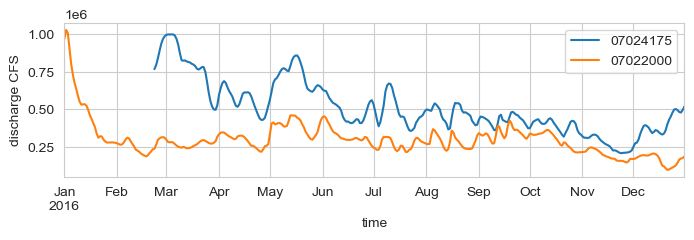

In [4]:
date_format="YYYY-MM-DDTHH:SS:MM"
upstream_sites = ["07022000" ]# , "03612600"]
main_site = "07024175"

param_cd =["00060"] 
param_name = ["mean discharge CFS"]
secondary_param_name = ["water temperature F", "air temperature F",]
secondary_param_cd = ["00011","00021"]


start="2016-01-01"
end="2016-12-31"

dfs=[]

mdf, meta = nwis.get_dv(sites=main_site, start=start, end=end, parameterCd=param_cd)
custom_plot(mdf["00060_Mean"], label=main_site)

for site in upstream_sites:
    df, meta = nwis.get_dv(sites=site, start=start, end=end, parameterCd=param_cd)
    dfs.append(df)
    custom_plot(df["00060_Mean"], label=site)

plt.legend()


In [9]:
def cross_corr( df1=pd.DataFrame, df2=pd.DataFrame,
                tag1="", tag2="",
#                start_date, end_date,  # mmm read data?
#                window_size=365,       # should I just use the bounds of the data? 
                shift_range=(-10,10)):
    """
    Cross correlation tool for the project. User is assumed to give dfs 
    with the same daily time index timezone
    """

    if df1.index[0].tz != df2.index[0].tz:
        raise(ValueError("time index zone is not the same in both dfs"))

    l_date = min(df1.index[0], df2.index[0])
    h_date = max(df1.index[-1], df2.index[-1])
    pd.DataFrame(index=pd.date_range(start=l_date, end=h_date, freq="D", tz=df1.index[0].tz))

    ccv=[]
    shifts = range(shift_range[0],shift_range[1]+1)
    for i in shifts:
        _df = pd.DataFrame()
        _df["1"] = df1[tag1]
        _df["2"] = df2[tag2].shift(-i)
        ccv.append(_df["1"].corr(_df["2"]))
    
    plt.scatter(shifts, ccv)
    ax = plt.gca()
    ax.xaxis.get_major_locator().set_params(integer=True)
    maxcv = shifts[np.argmax(ccv)]
    plt.title("Cross correlation function")
    plt.xlabel(f"time lag (days)")
    return maxcv, ccv

In [109]:
print(dfs[1].index[-1])
print(dfs[0].index[-1])
print(min(dfs[0].index[0],dfs[1].index[1]))

2017-01-01 00:00:00+00:00
2017-01-01 00:00:00+00:00
2016-01-01 00:00:00+00:00


(-1,
 [0.1822786332405932,
  0.2047514519181705,
  0.23240106398520427,
  0.2646436069464056,
  0.3015598843957222,
  0.34330916443358583,
  0.38754005674553943,
  0.4292002680687435,
  0.4607960160778089,
  0.47483298033855775,
  0.46930658774031625,
  0.4536101598183442,
  0.43352313531156433,
  0.4140055461150431,
  0.39794233528046896,
  0.3859893175139452,
  0.37838535917719146,
  0.375401023425915,
  0.37707669462893095,
  0.38274704414385474,
  0.3891896143924845])

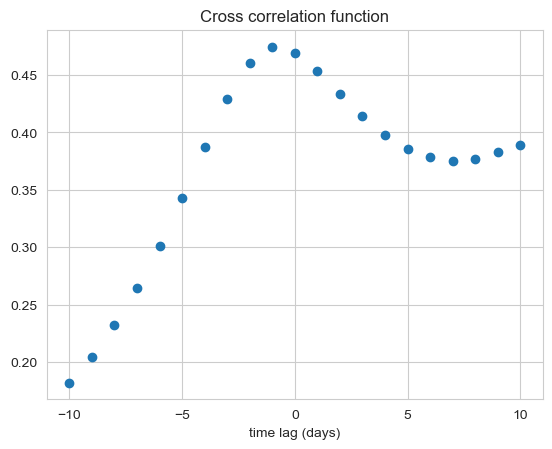

In [11]:
max_lag, corrs = cross_corr(mdf, dfs[0], tag1="00060_Mean", tag2="00060_Mean", shift_range=(-10,10))

(-1,
 [0.7703228023039905,
  0.779275647713883,
  0.7900478444417058,
  0.804236953365913,
  0.8221491811929043,
  0.8432798732433694,
  0.8652114608547481,
  0.8836091473732611,
  0.8956499691838115,
  0.8974394053333664,
  0.8843217097075643,
  0.8606099264728618,
  0.8305044780823181,
  0.797248871420203,
  0.765932126286209,
  0.7387841406562791,
  0.7156420377280552,
  0.6962991451424568,
  0.6800696233731847,
  0.665470865571083,
  0.6507366988500449])

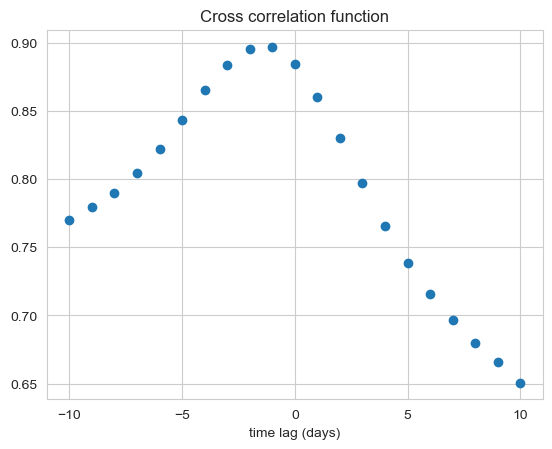

In [12]:
cross_corr(mdf, dfs[1], tag1="00060_Mean", tag2="00060_Mean", shift_range=(-10,10))

{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None}
I did came in
{'kind': 'scatter', 'title': '', 'xlabel': 'new1', 'ylabel': 'new2', 'legend': None, 'x': 'new1', 'y': 'new2', 's': 1}


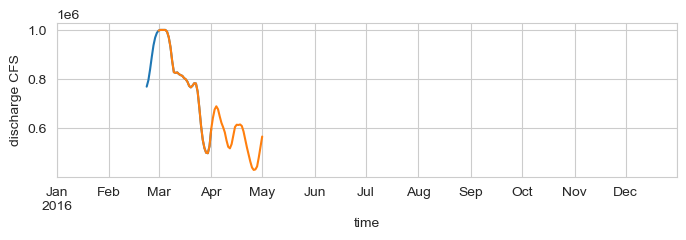

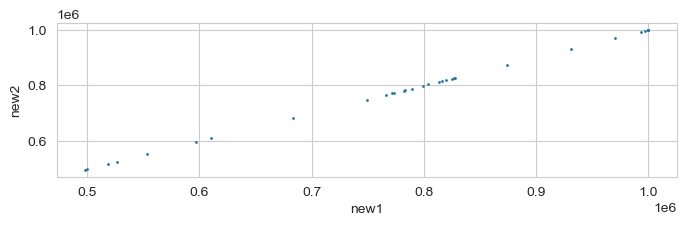

In [88]:
# df, _ = nwis.get_dv(sites=main_site, start="2016-01-01",end="2017-01-01", parameterCd=param_cd)
testdf= pd.DataFrame(index=pd.date_range(start="2016-01-01", end="2016-12-31",freq="D", tz=df.index[0].tz))
testdf["new1"]=df["00060_Mean"]["2016-01-25":"2016-04-01"]
testdf["new2"]=df["00060_Mean"]["2016-03-01":"2016-05-01"]

#print(testdf["new1"].values)
#print(testdf["new2"].values)

custom_plot(testdf["new1"])
custom_plot(testdf["new2"])
custom_plot(testdf, xtag="new1", ytag="new2", xlabel="new1", ylabel="new2")

In [77]:
print(df.index[0].tz)
print(testdf.index[53])
print(df.index[0]-testdf.index[53])

UTC
2016-02-23 00:00:00+00:00
0 days 00:00:00


In [85]:
xxx={"a":"hey","c":5}
xxx["b"]="lala"
xxx

{'a': 'hey', 'c': 5, 'b': 'lala'}

-0.4037051736146309
-0.4472135954999579
-0.4666666666666667
-0.3370682771697426
0.2581988897471611
0.46225016352102427
0.8696263565463045
0.5163977794943222
-0.356034497458156
-0.5999999999999999


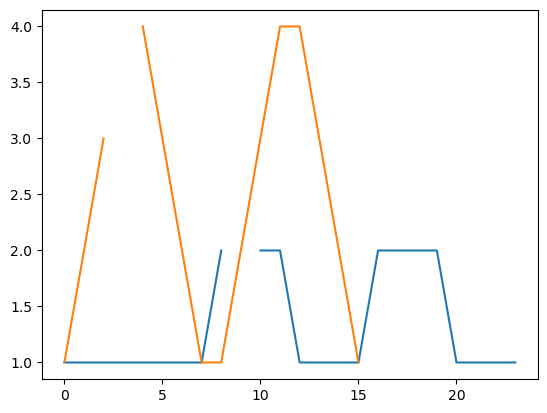

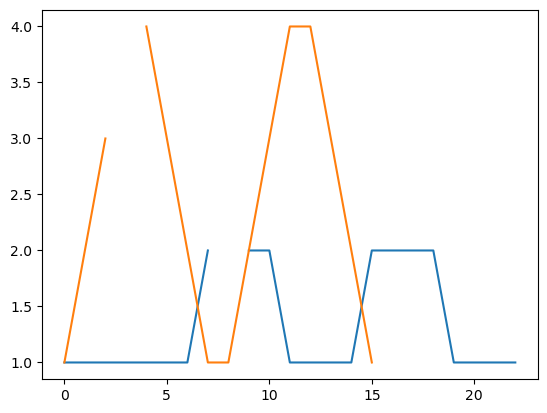

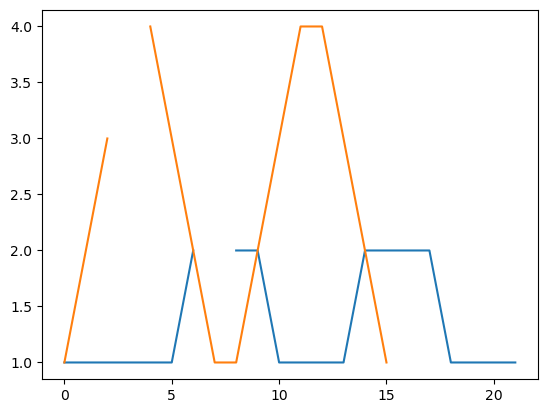

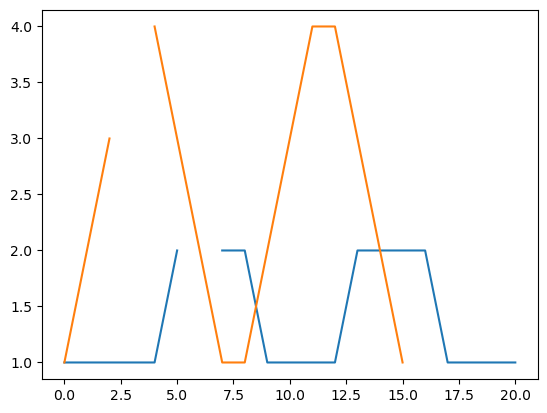

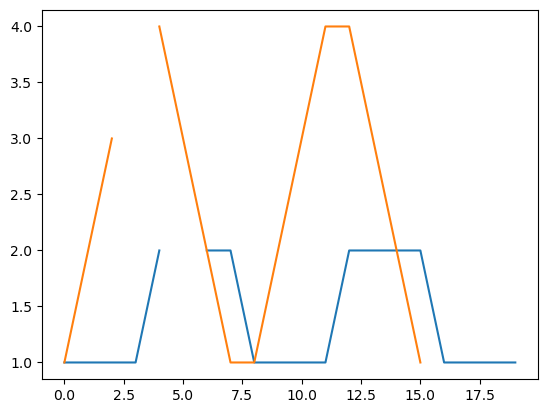

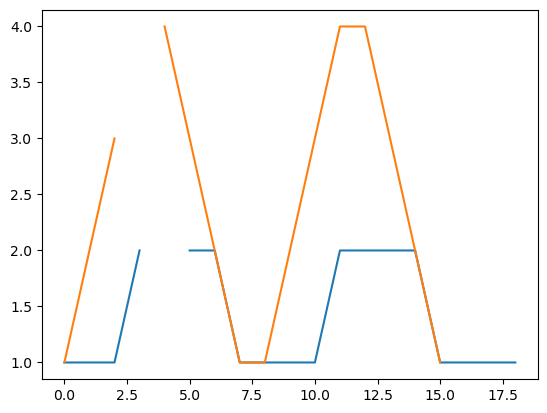

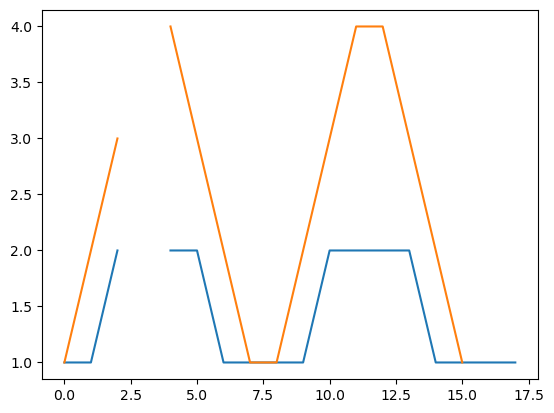

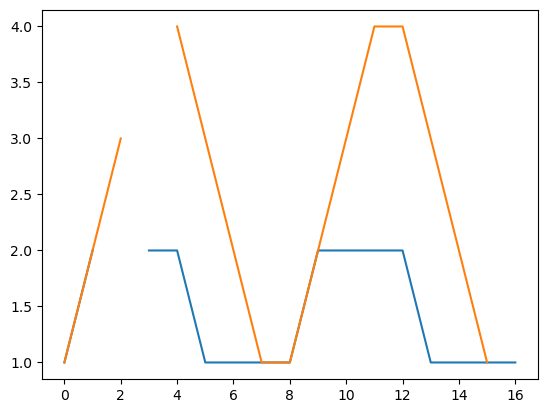

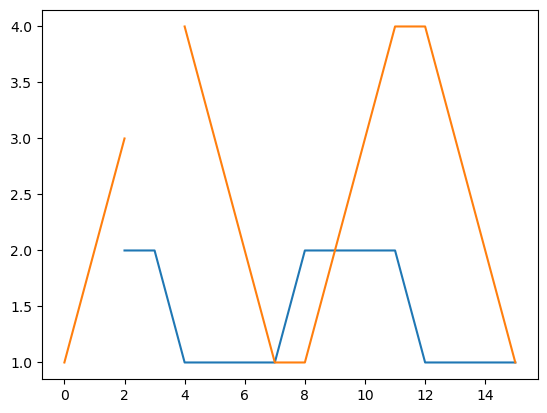

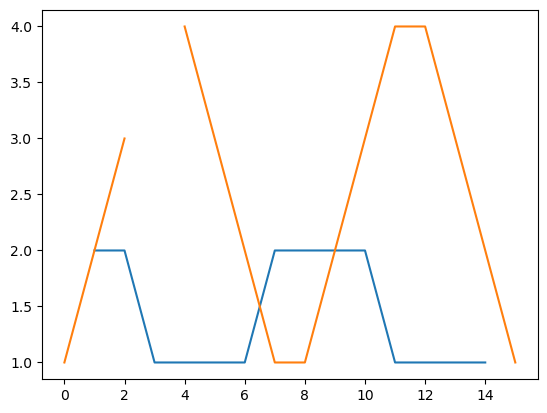

In [1]:
# graph for the cross correlation
import pandas as pd
import matplotlib.pyplot as plt

xxx=pd.DataFrame()
yyy=pd.DataFrame()
xxx["a"]=[1,1,1,1,1,1,1,1,2,None,2,2,1,1,1,1,2,2,2,2,1,1,1,1]
yyy["b"]=[1,2,3,None,4,3,2,1,1,2,3,4,4,3,2,1]
n=10

for i in range(10):
    plt.figure()
    xxx["a"].shift(-i).plot()
    yyy["b"].plot()
    df=pd.DataFrame()
    df["1"] = yyy["b"][0:n].values
    df["2"] = xxx["a"].shift(-i)[0:n].values
    print(df["1"].corr(df["2"]) )